In [1]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import project_path  # noqa: F401
from IPython.display import Markdown, display
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from collections import defaultdict

import experiments.setup  # noqa: F401
from experiments.utils import iterate_simulation_results

In [2]:
current_dir = Path().resolve().parent.parent
out_path = current_dir.joinpath("results/simulations/")
out_path.mkdir(exist_ok=True)

token_distribution_path = current_dir.joinpath("data/stETH_token_distribution.csv")

In [3]:
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline

In [4]:
from experiments.templates.withdrawal_queue_replacement import SEED, TIMESTEPS

PRESENTED_RUN = 0
simulation_name = "signalling_thresholds_sweep_under_proposal_with_attack"
simulation_path = out_path.joinpath(f"{simulation_name}/")


# def open_csv(simulation_path: Path, file_name: str):
#     actors_file = simulation_path.joinpath(f"{file_name}/")

#     actors_df = pd.read_csv(actors_file)

#     return actors_df


# actors_df = open_csv(simulation_path, "actors.csv")
# post_processing = open_csv(simulation_path, "post_processing.csv")

In [232]:
import time

def get_common_columns_to_extract_from_simulation_result():
    return ['first_seal_rage_quit_support', 'second_seal_rage_quit_support', 'seed', 'timestep']

def extract_dg_state_data(run_df):
    run_df["dg_state"] = run_df.dual_governance.apply(lambda x: x.state.state)
    run_df["dg_state_value"] = run_df["dg_state"].apply(lambda state: state.value)
    run_df["dg_state_name"] = run_df["dg_state"].apply(lambda state: state.name)
    run_df["dg_dynamic_timelock_hours"] = run_df.dual_governance.apply(
        lambda dg: dg.state._calc_dynamic_timelock_duration(dg.state.signalling_escrow.get_rage_quit_support()).to_seconds()
        / 60 / 60 / 24)

    columns_to_extract = get_common_columns_to_extract_from_simulation_result()
    columns_to_extract += ['dg_state_value', 'dg_state_name', 'dg_dynamic_timelock_hours']
    extracted_data = run_df[columns_to_extract].copy()
    return extracted_data

def extract_proposal_data(run_df):
    run_df['last_cancelled_proposal_id'] = run_df['dual_governance'].apply(lambda dg: dg.timelock.proposals.state.last_canceled_proposal_id)
    cancelled_proposals = set(run_df['last_cancelled_proposal_id'].unique())

    simulation_start = (
        run_df[(run_df["timestep"] == 0)]
        .time_manager.apply(lambda tm: tm.current_time)
        .iloc[0]
        .timestamp()
    )
    proposals_info = (
        run_df.dual_governance.apply(lambda dg: dg.timelock.proposals.state.proposals).iloc[-1]
    )
    proposal_dict = defaultdict(list)
    for proposal in proposals_info:
        proposal_dict["id"].append(proposal.id)
        proposal_dict["status"].append(proposal.status)
        proposal_dict["submittedAt"].append((proposal.submittedAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict["scheduledAt"].append((proposal.scheduledAt.to_seconds() - simulation_start) / 3600 / 3)
        proposal_dict["executedAt"].append((proposal.executedAt.to_seconds() - simulation_start) / 3600 / 3)
    for proposal_id in proposal_dict['id']:
        if proposal_id in cancelled_proposals:
            row_when_cancelled = np.argmax(run_df['last_cancelled_proposal_id'] == proposal_id)
            timestep_when_cancelled = run_df.iloc[row_when_cancelled].timestep
            proposal_dict['cancelledAt'].append(timestep_when_cancelled)
        else:
            proposal_dict['cancelledAt'].append(None)

    common_data = run_df[get_common_columns_to_extract_from_simulation_result()].drop(columns='timestep')
    for col in common_data:
        proposal_dict[col] = [common_data[col].iloc[0] for _ in range(len(proposal_dict['id']))]
        
    proposal_df = pd.DataFrame(proposal_dict).set_index("id")
    return proposal_df

def aggregate_actor_data(actor_df):
    actor_df['total_balance'] = actor_df.st_eth_balance + actor_df.wstETH_balance
    actor_df['total_locked'] = actor_df.st_eth_locked + actor_df.wstETH_locked
    
    total_initial_balance = actor_df[actor_df['timestep'] == 0]['total_balance'].sum()
    total_actors = len(actor_df[actor_df['timestep'] == 0]['id'].unique())
    actor_df['actor_locked'] = actor_df['total_locked'] > 0
    actor_df_final = actor_df.groupby(get_common_columns_to_extract_from_simulation_result()).agg(
        {'total_balance': 'sum',
         'total_locked': 'sum',
         'actor_locked': 'sum',
         'system_health': 'sum'
        }).reset_index()
    initial_system_health = actor_df[actor_df['timestep'] == 0]['health'].sum()
    actor_df_final['total_locked_ratio'] = actor_df_final['total_locked'] / total_initial_balance
    actor_df_final['actor_locked_ratio'] = actor_df_final['actor_locked'] / total_actors
    actor_df_final['system_health_ratio'] = actor_df_final['system_health'] / initial_system_health
    return actor_df_final

def extract_actor_data(run_df):
    common_columns = get_common_columns_to_extract_from_simulation_result()
    run_df_actors = run_df[common_columns + ['actors']].explode('actors')
    actor_columns = [
        'st_eth_balance',
        'initial_st_eth_balance',
        'st_eth_locked',
        'wstETH_balance',
        'initial_wstETH_balance',
        'wstETH_locked',
        'health',
        'id'
    ]
    for col in actor_columns:
        run_df_actors[col] = run_df_actors.actors.apply(lambda actor: vars(actor)[col])
    actor_df = run_df_actors[common_columns + actor_columns]
    aggregated_actor_df = aggregate_actor_data(actor_df)
    return aggregated_actor_df
    

from experiments.utils import iterate_simulation_results

simulation_name = "signalling_thresholds_sweep_under_proposal_with_attack"
simulation_path = out_path.joinpath(simulation_name)
hashes = [p for p in simulation_path.iterdir() if p.is_dir()]

dg_state_dfs = []
proposal_dfs = []
actor_dfs = []
start = time.time()
for run_df in iterate_simulation_results(simulation_path):
    dg_state_dfs.append(extract_dg_state_data(run_df))
    proposal_dfs.append(extract_proposal_data(run_df))
    actor_dfs.append(extract_actor_data(run_df))
dg_state_df = pd.concat(dg_state_dfs, ignore_index=True)
proposal_df = pd.concat(proposal_dfs, ignore_index=True)
actors_df = pd.concat(actor_dfs, ignore_index=True)

for df in [dg_state_df, proposal_df, actors_df]:
    df['first_seal_rage_quit_support'] /= 10**16
    df['second_seal_rage_quit_support'] /= 10 **16

del dg_state_dfs, proposal_dfs, actor_dfs

print(f'Data loaded in {time.time() - start:.3f} sec')

yield: 181.263 sec


In [6]:
import time

from experiments.utils import iterate_simulation_results, extract_dg_state_data, extract_proposal_data, extract_actor_data

simulation_name = "signalling_thresholds_sweep_under_proposal_with_attack"
simulation_path = out_path.joinpath(simulation_name)
hashes = [p for p in simulation_path.iterdir() if p.is_dir()]

dg_state_dfs = []
proposal_dfs = []
actor_dfs = []
start = time.time()
for run_df in iterate_simulation_results(simulation_path):
    dg_state_dfs.append(extract_dg_state_data(run_df))
    proposal_dfs.append(extract_proposal_data(run_df))
    actor_dfs.append(extract_actor_data(run_df))
dg_state_df = pd.concat(dg_state_dfs, ignore_index=True)
proposal_df = pd.concat(proposal_dfs, ignore_index=True)
actors_df = pd.concat(actor_dfs, ignore_index=True)

for df in [dg_state_df, proposal_df, actors_df]:
    df['first_seal_rage_quit_support'] /= 10**16
    df['second_seal_rage_quit_support'] /= 10 **16

del dg_state_dfs, proposal_dfs, actor_dfs

print(f'Data loaded in {time.time() - start:.3f} sec')

Data loaded in 255.884 sec


In [10]:
dg_state_df = dg_state_df[dg_state_df['second_seal_rage_quit_support'] == 15]
proposal_df = proposal_df[proposal_df['second_seal_rage_quit_support'] == 15]
actors_df = actors_df[actors_df['second_seal_rage_quit_support'] == 15]
for df in [dg_state_df, proposal_df, actors_df]:
    df['thresh1'] = df['first_seal_rage_quit_support']
    df['thresh2'] = df['second_seal_rage_quit_support']

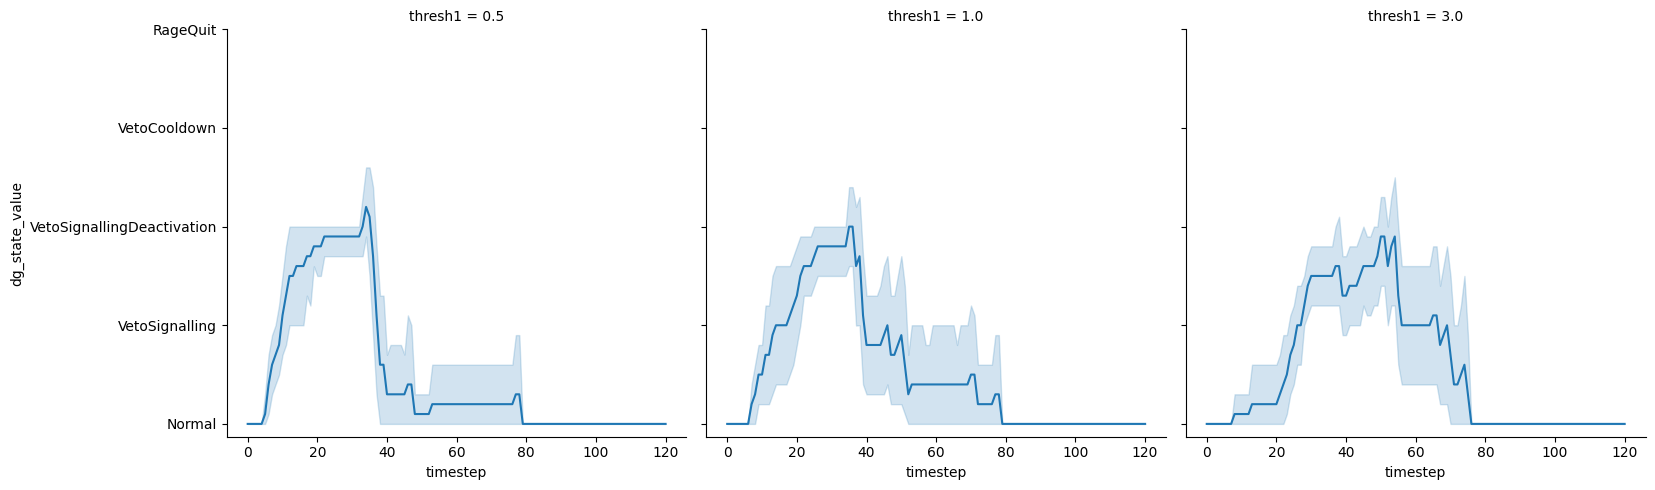

In [11]:
sns.relplot(dg_state_df, x='timestep', y='dg_state_value', col='thresh1',
            kind='line'
           )

state_names = {1: "Normal", 2: "VetoSignalling", 3: "VetoSignallingDeactivation", 4: "VetoCooldown", 5: "RageQuit"}
plt.gca().set_yticks(list(state_names.keys()), labels=list(state_names.values()))

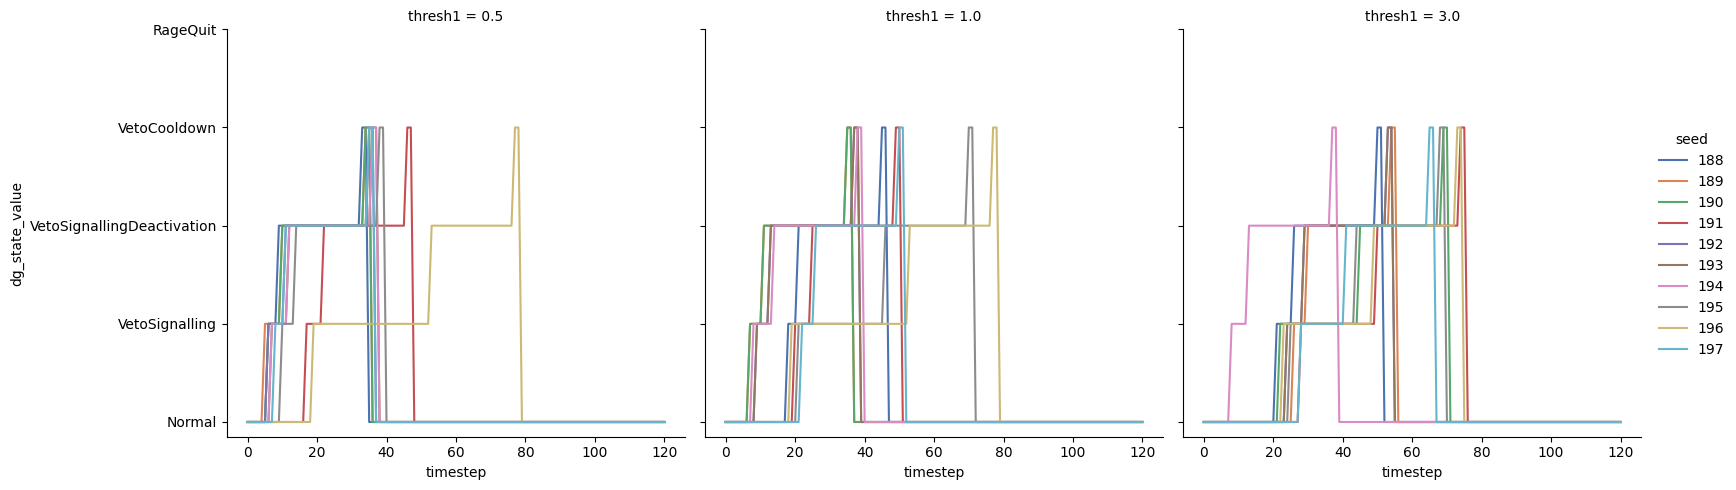

In [12]:
sns.relplot(dg_state_df, x='timestep', y='dg_state_value', col='thresh1',
            kind='line', hue='seed', palette='deep'
           )

state_names = {1: "Normal", 2: "VetoSignalling", 3: "VetoSignallingDeactivation", 4: "VetoCooldown", 5: "RageQuit"}
plt.gca().set_yticks(list(state_names.keys()), labels=list(state_names.values()))

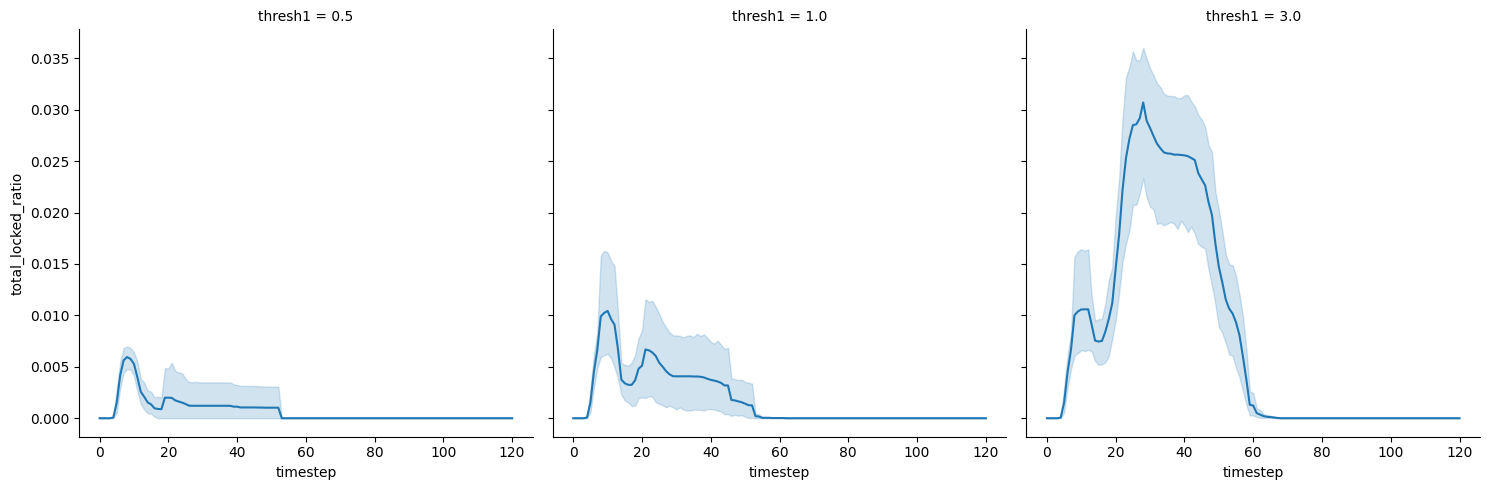

In [13]:
sns.relplot(actors_df, x='timestep', y='total_locked_ratio', col='thresh1',
            kind='line'
           )

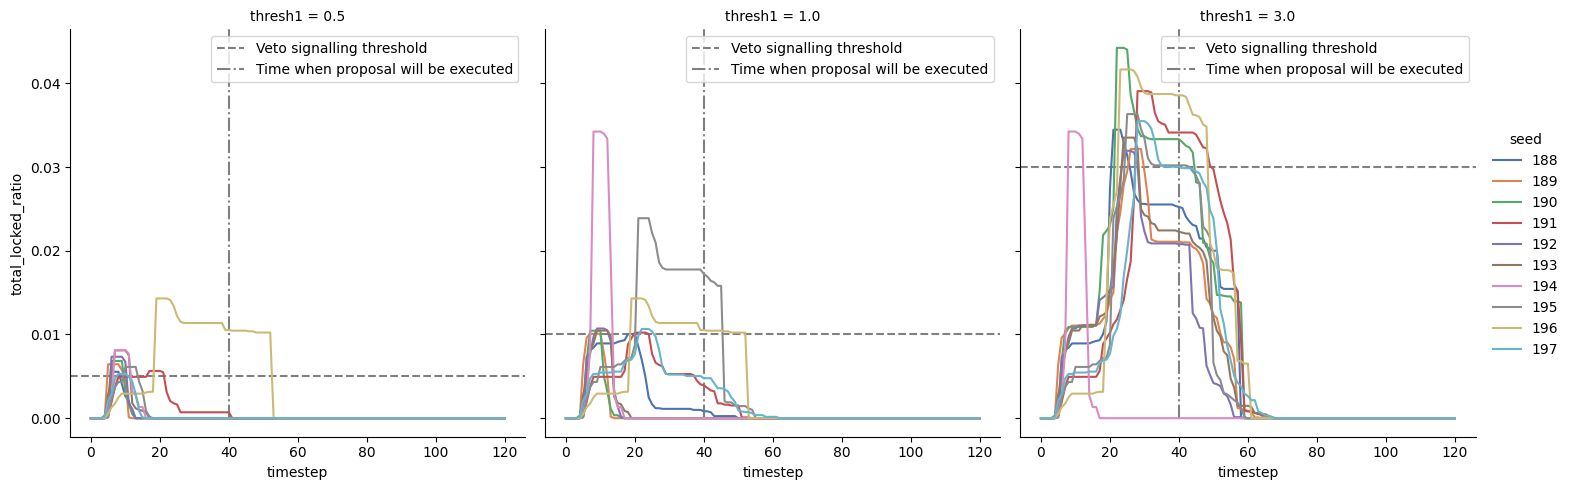

In [14]:
actors_df['sseed'] = 's' + actors_df['seed'].map(str)
a = sns.relplot(actors_df, x='timestep', y='total_locked_ratio', col='thresh1',
            kind='line', hue='seed', palette='deep'
           )
for thresh_val in a.col_names:
    ax = a.axes_dict[thresh_val]
    xlim = ax.get_xlim()
    thresh_line = ax.plot(xlim, np.array([thresh_val, thresh_val]) / 100, linestyle='--', color='gray', zorder=0, label='Veto signalling threshold')
    ax.set_xlim(xlim)

    ylim = ax.get_ylim()
    execution_timestep = 5 * 24 / 3
    execution_time_line = ax.plot([execution_timestep, execution_timestep], [0, ylim[1]], color='gray', linestyle='-.', zorder=0, label='Time when proposal will be executed')
    ax.set_ylim(ylim)

    ax.legend([thresh_line[0], execution_time_line[0]], ['Veto signalling threshold', 'Time when proposal will be executed'])

Text(0.5, 28.999999999999986, 'First seal rage quit support')

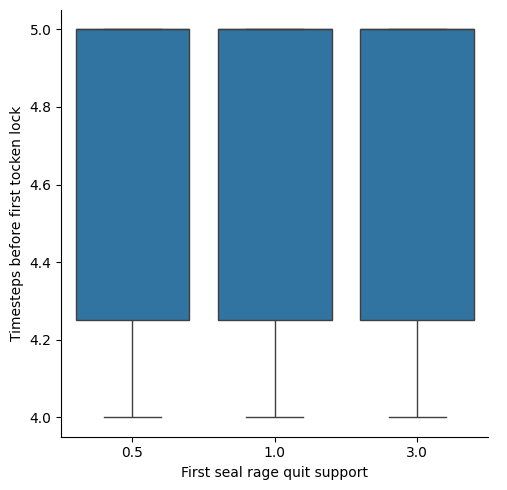

In [15]:
time_to_react_df = actors_df.groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).apply(lambda x: x[x['actor_locked'] > 0].iloc[0]).reset_index(drop=True)

sns.catplot(time_to_react_df, x='thresh1', y='timestep', kind='box')
plt.gca().set_ylabel('Timesteps before first tocken lock')
plt.gca().set_xlabel('First seal rage quit support')

Text(0.5, 28.999999999999986, 'First seal rage quit support')

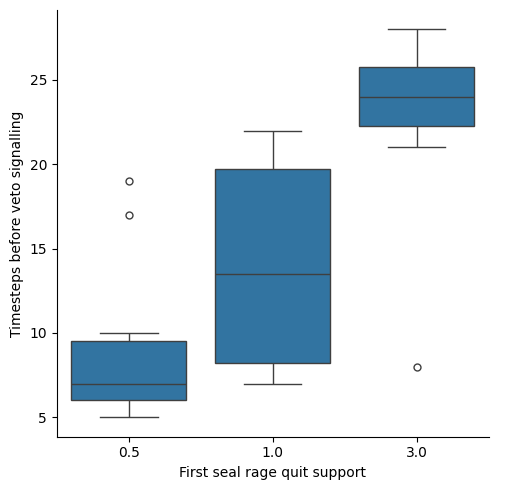

In [16]:
time_to_veto_df = dg_state_df.groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).apply(lambda x: x[x['dg_state_value'] == 2].iloc[0]).reset_index(drop=True)

sns.catplot(time_to_veto_df, x='thresh1', y='timestep', kind='box')
plt.gca().set_ylabel('Timesteps before veto signalling')
plt.gca().set_xlabel('First seal rage quit support')

Text(0.5, 29.140624999999986, 'First seal rage quit support')

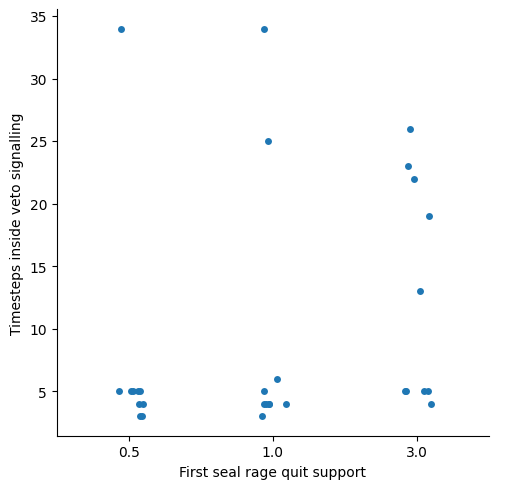

In [17]:
time_in_veto_df = dg_state_df[dg_state_df['dg_state_value'] == 2].groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).count().reset_index()

sns.catplot(time_in_veto_df, x='first_seal_rage_quit_support', y='timestep', kind='strip')
plt.gca().set_ylabel('Timesteps inside veto signalling')
plt.gca().set_xlabel('First seal rage quit support')

In [18]:
time_in_veto_df[time_in_veto_df['timestep'] == 34]

,first_seal_rage_quit_support,second_seal_rage_quit_support,seed,timestep,dg_state_value,dg_state_name,dg_dynamic_timelock_hours,thresh1,thresh2
8,0.50,15.00,196,34,34,34,34,34,34
18,1.00,15.00,196,34,34,34,34,34,34


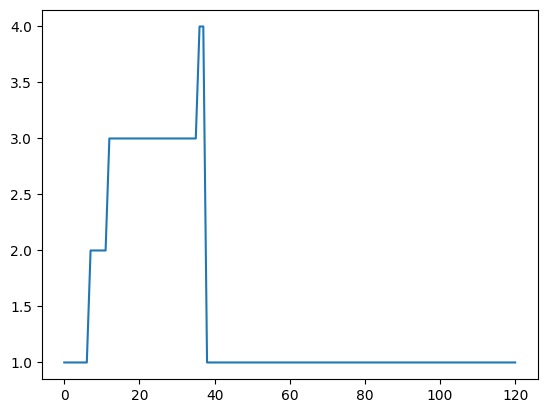

In [19]:
view = dg_state_df[(dg_state_df['first_seal_rage_quit_support'] == 0.5) & (dg_state_df['second_seal_rage_quit_support'] == 15.) & (dg_state_df['seed'] == 194)]
plt.plot(view.timestep, view.dg_state_value)
# view = dg_state_df[(dg_state_df['first_seal_rage_quit_support'] == 0.5) & (dg_state_df['second_seal_rage_quit_support'] == 15.) & (dg_state_df['seed'] == 195)]
# plt.plot(view.timestep, view.dg_state_value)

(-6.0, 126.0)

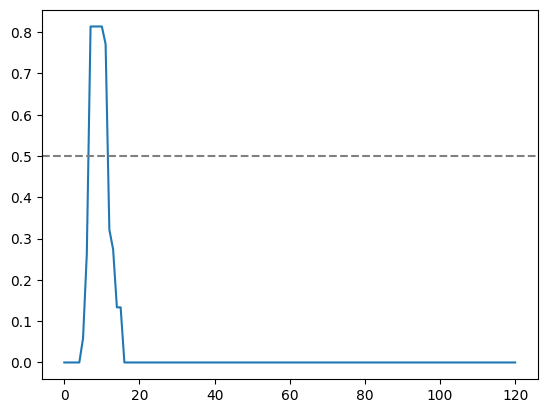

In [20]:
view = actors_df[(actors_df['first_seal_rage_quit_support'] == 0.5) & (actors_df['second_seal_rage_quit_support'] == 15.) & (dg_state_df['seed'] == 194)]
plt.plot(view.timestep, view.total_locked_ratio * 100)
xlim = plt.xlim()
plt.plot(plt.xlim(),[0.5,0.5], linestyle='--', color='gray')
plt.xlim(xlim)

Text(0.5, 29.140624999999986, 'First seal rage quit support')

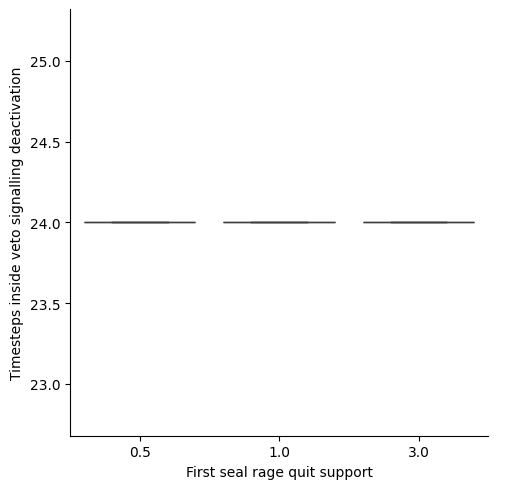

In [21]:
time_in_veto_df = dg_state_df[dg_state_df['dg_state_value'] == 3].groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).count().reset_index()

sns.catplot(time_in_veto_df, x='first_seal_rage_quit_support', y='timestep', kind='box')
plt.gca().set_ylabel('Timesteps inside veto signalling deactivation')
plt.gca().set_xlabel('First seal rage quit support')

Text(0.5, 29.140624999999986, 'First seal rage quit support')

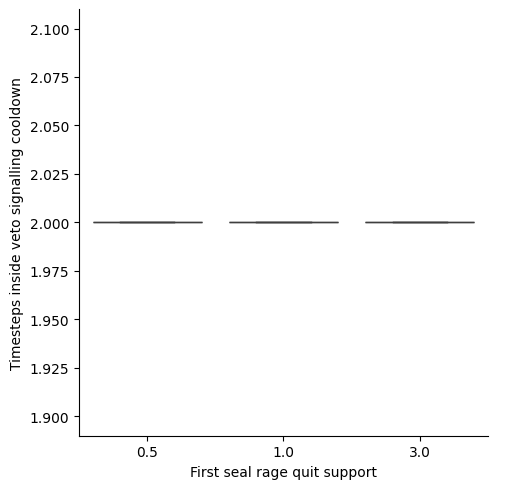

In [22]:
time_in_veto_df = dg_state_df[dg_state_df['dg_state_value'] == 4].groupby(
    ['first_seal_rage_quit_support',
     'second_seal_rage_quit_support',
     'seed']
).count().reset_index()

sns.catplot(time_in_veto_df, x='first_seal_rage_quit_support', y='timestep', kind='box')
plt.gca().set_ylabel('Timesteps inside veto signalling cooldown')
plt.gca().set_xlabel('First seal rage quit support')